In [1]:
import pandas as pd
import seaborn as sns
import geopandas as gpd

import matplotlib.pyplot as plt

from shapely.geometry import Point


In [2]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series


## Samples spatio-temporal distribution and distance between sites

In [3]:
all_data_clean = pd.read_csv('../all_data_clean.csv')

#### Number of sites and sample temporal distribution

In [4]:
print('Number of flow sites:', len(all_data_clean.flow_site_id.unique()))
print('Number of snow depth sites:', len(all_data_clean.snow_site_id.unique()))
print('Number of temperature sites:', len(all_data_clean.temp_site_id.unique()))
print('Number of precipitation sites:', len(all_data_clean.prec_site_id.unique()))

Number of flow sites: 22
Number of snow depth sites: 21
Number of temperature sites: 22
Number of precipitation sites: 22


In [5]:
print('Total sample number:', len(all_data_clean))
print('Percentage of extreme snowmelt:', len(all_data_clean[all_data_clean.binary == 1]) / len(all_data_clean)*100, '%')

Total sample number: 108254
Percentage of extreme snowmelt: 5.100966246050954 %


In [6]:
def percent_extreme_snowmelt(data):
	return len(data[data == 1]) / len(data)*100

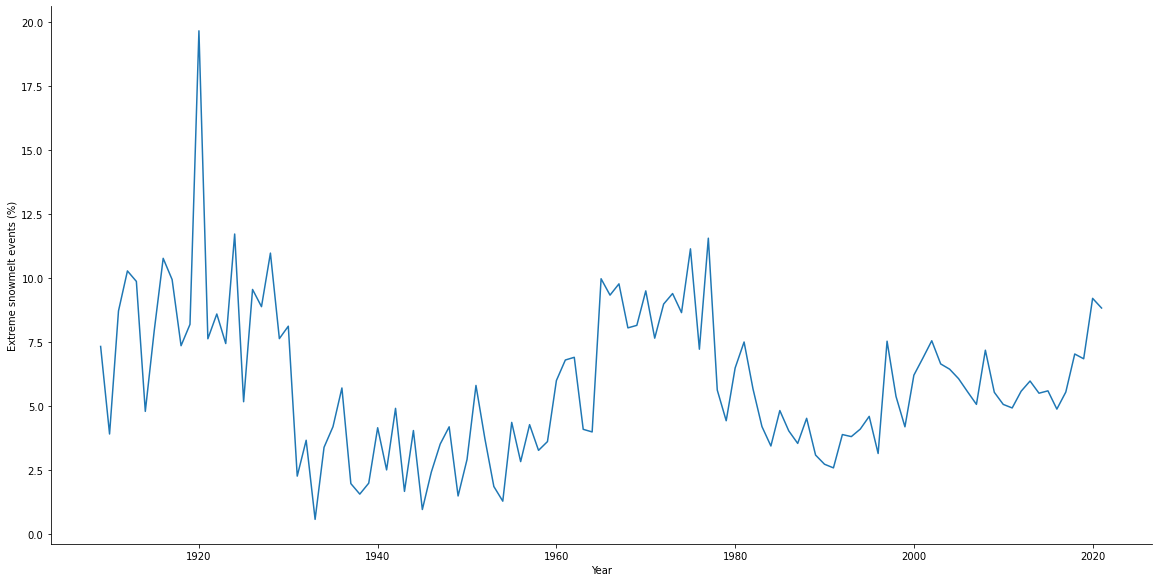

In [7]:
all_data_clean['date'] = pd.to_datetime(all_data_clean['date'])
all_data_clean['year'] = all_data_clean.date.dt.year
stats = all_data_clean.groupby('year')['binary'].agg([percent_extreme_snowmelt])
g = sns.relplot(x="year", y="percent_extreme_snowmelt", data=stats, kind="line", height=8, aspect=2)
g.set(xlabel='Year', ylabel='Extreme snowmelt events (%)')


In [8]:
## Recreate rolled dataframe with minimal features and undersample it (2 days, time lag zero)
all_data_clean = pd.read_csv('../all_data_clean.csv')
df_rolled = roll_time_series(
    all_data_clean[['date', 'flow_site_id', 'prec', 'temp', 'flow', 'binary']], column_id="flow_site_id", column_sort="date", max_timeshift=2, min_timeshift=2 - 1, n_jobs=20)
X_features_all = extract_features(
	df_rolled.drop(["binary", "flow_site_id"], axis=1), column_id='id', column_sort='date',
	n_jobs=20, disable_progressbar=False, default_fc_parameters=MinimalFCParameters())


Feature Extraction: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


In [9]:
X_features_all['unique_id'] = X_features_all.index

all_data_clean['shifted_date'] = pd.to_datetime(
    all_data_clean.date) + pd.Timedelta(days=10)
all_data_clean['shifted_date'] = all_data_clean['shifted_date'].dt.strftime(
    '%Y-%m-%d')
all_data_clean['unique_id'] = list(
    zip(all_data_clean.flow_site_id, all_data_clean.shifted_date))
all_data_clean = all_data_clean.dropna()

X_features_all = X_features_all.reset_index(drop=True)

X_features_all = pd.merge(X_features_all, all_data_clean[[
                          'binary', 'unique_id']], how='left', on='unique_id')
X_features_all = X_features_all.set_index(
    X_features_all['unique_id'], drop=True)
X_features_all = X_features_all.dropna()
X_features_all.head()


,prec__sum_values,prec__median,prec__mean,prec__length,prec__standard_deviation,prec__variance,prec__root_mean_square,prec__maximum,prec__minimum,temp__sum_values,...,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum,unique_id,binary
unique_id,,,,,,,,,,,,,,,,,,,,,
"(114.0, 1909-01-11)",0.2,0.0,0.066667,3.0,0.094281,0.008889,0.115470,0.2,0.0,-16.0,...,7.4,7.5,3.0,1.414214e-01,2.000000e-02,7.501333,7.7,7.4,"(114.0, 1909-01-11)",0.0
"(114.0, 1909-01-12)",0.4,0.2,0.133333,3.0,0.094281,0.008889,0.163299,0.2,0.0,-10.5,...,7.4,7.4,3.0,8.881784e-16,7.888609e-31,7.400000,7.4,7.4,"(114.0, 1909-01-12)",0.0
"(114.0, 1909-01-13)",0.4,0.2,0.133333,3.0,0.094281,0.008889,0.163299,0.2,0.0,-30.2,...,7.4,7.4,3.0,8.881784e-16,7.888609e-31,7.400000,7.4,7.4,"(114.0, 1909-01-13)",0.0
"(114.0, 1909-01-14)",0.7,0.2,0.233333,3.0,0.205480,0.042222,0.310913,0.5,0.0,-47.6,...,7.4,7.4,3.0,8.881784e-16,7.888609e-31,7.400000,7.4,7.4,"(114.0, 1909-01-14)",0.0
"(114.0, 1909-01-15)",2.4,0.5,0.800000,3.0,0.804156,0.646667,1.134313,1.9,0.0,-47.1,...,7.4,7.3,3.0,1.414214e-01,2.000000e-02,7.301370,7.4,7.1,"(114.0, 1909-01-15)",0.0


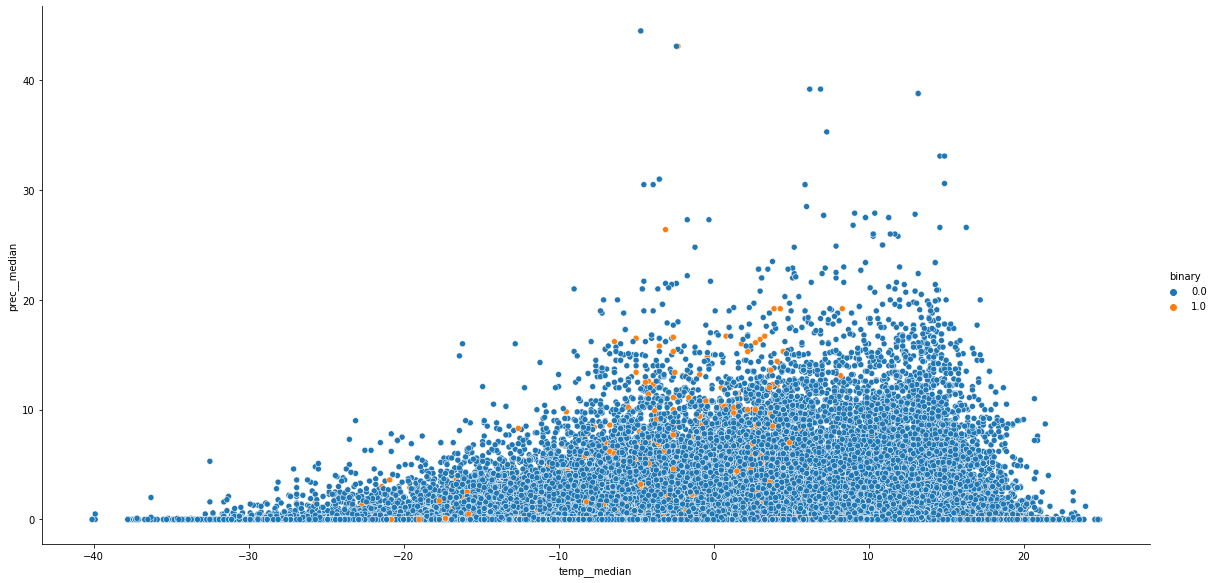

In [10]:
g = sns.relplot(x="temp__median", y="prec__median", hue='binary', data=X_features_all, kind="scatter", height=8, aspect=2)


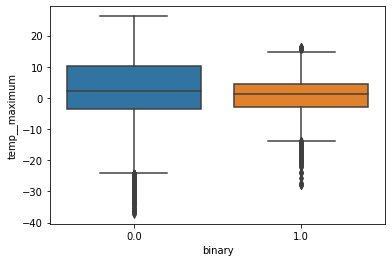

In [11]:
g = sns.boxplot(x="binary", y="temp__maximum", data=X_features_all)

#### Export shapefile with snow depth sites

In [12]:
snow_site_ids = all_data_clean.snow_site_id.unique()

In [13]:
snow_sites = pd.read_csv('../snow_sites.csv', low_memory=False)
snow_sites_clean = snow_sites[snow_sites.site_id.isin(snow_site_ids)]

In [14]:
snow_stats = all_data_clean.groupby('snow_site_id')['binary'].agg([percent_extreme_snowmelt])
snow_stats['site_id'] = snow_stats.index
snow_sites_used = pd.merge(snow_sites_clean, snow_stats, on='site_id', how='left')
snow_sites_used

,site_id,name,latitude,longitude,year_count,obs_per_year,percent_extreme_snowmelt
0,75280,Arvingetorp,57.4496,15.0344,37,178.432432,7.193230
1,62180,Barkåkra,56.2900,12.8463,51,148.098039,0.649240
2,122360,Fjällnäs,62.5772,12.2223,35,156.000000,11.989564
3,169880,Jokkmokk,66.6135,19.8316,136,150.154412,6.217009
4,192830,Karesuando,68.4425,22.4453,126,157.849206,1.649832
5,167980,Kvikkjokk-Årrenjarka,66.8834,18.0226,134,199.171642,5.595185
6,134470,Laxviken,63.7901,14.6784,35,127.514286,8.350996
7,144560,Leipikvattnet,64.9290,14.1563,74,201.891892,12.529724
8,63050,Ljungbyhed,56.0752,13.2318,47,139.085106,0.931677
9,81130,Ljungskile,58.2159,11.9321,15,306.933333,2.163355


In [15]:
snow_sites_used['geometry'] = snow_sites_used.apply(
    lambda row: Point(row.longitude, row.latitude), axis=1)
gdf = gpd.GeoDataFrame(snow_sites_used, geometry=snow_sites_used.geometry)
gdf.to_file(driver='ESRI Shapefile', crs="EPSG:4326",
            filename="../snow_sites/snow_sites_used.shp")


/home/cecilia/.local/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:91: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)
<ipython-input-15-f6ba6840d5e3>:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(driver='ESRI Shapefile', crs="EPSG:4326",


## Model performance comparison across factors

In [16]:
results = pd.read_excel('../results_v6.ods')
results['Flow_Temp_Prec'] = results['Flow'] + '_' + results['Temp'] + '_' + results['Prec']
time_series_dict = {'No_No_Yes' : 'Precipitation only', 'No_Yes_No' : 'Temperature only', 
'No_Yes_Yes' : 'Temperature and precipitation', 'Yes_No_No' : 'Flow only', 'Yes_No_Yes' : 'Flow and precipitation', 
'Yes_Yes_No' : 'Flow and temperature', 'Yes_Yes_Yes' : 'Flow, temperature and precipitation'}
results['time_series'] = results['Flow_Temp_Prec'].map(time_series_dict)
results


,n_days,time_lag,eval_type,param_type,year,params,score,model,variables,n_features,n_samples,Flow,Prec,Temp,Flow_Temp_Prec,time_series
0,2,0,site,Minimal,No,"{'max_depth': 5, 'max_features': 5, 'n_estimat...",0.931493,Random Forest,"Index(['prec__sum_values', 'prec__median', 'pr...",5,11042,No,Yes,No,No_No_Yes,Precipitation only
1,2,0,site,Minimal,Yes,"{'max_depth': 5, 'max_features': 2, 'n_estimat...",0.930442,Random Forest,"Index(['prec__sum_values', 'prec__median', 'pr...",6,11042,No,Yes,No,No_No_Yes,Precipitation only
2,2,5,site,Minimal,No,"{'max_depth': 10, 'max_features': 2, 'n_estima...",0.929182,Random Forest,"Index(['prec__sum_values', 'prec__median', 'pr...",5,10008,No,Yes,No,No_No_Yes,Precipitation only
3,2,5,site,Minimal,Yes,"{'max_depth': 1, 'max_features': 3, 'n_estimat...",0.919202,Random Forest,"Index(['prec__sum_values', 'prec__median', 'pr...",6,10008,No,Yes,No,No_No_Yes,Precipitation only
4,10,0,site,Selected,Yes,"{'max_depth': 5, 'max_features': 2, 'n_estimat...",0.916564,Random Forest,Index(['flow__variance_larger_than_standard_de...,142,11032,Yes,No,No,Yes_No_No,Flow only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,2,10,site,Minimal,Yes,"{'svc__C': 100, 'svc__dual': True, 'svc__max_i...",0.675708,SVC,"Index(['flow__sum_values', 'flow__standard_dev...",7,9376,Yes,No,Yes,Yes_Yes_No,Flow and temperature
1324,30,10,site,Minimal,Yes,"{'svc__C': 100, 'svc__dual': True, 'svc__max_i...",0.673877,SVC,"Index(['flow__sum_values', 'flow__median', 'fl...",9,9360,Yes,No,Yes,Yes_Yes_No,Flow and temperature
1325,5,10,site,Minimal,Yes,"{'svc__C': 100, 'svc__dual': True, 'svc__max_i...",0.651532,SVC,"Index(['flow__sum_values', 'flow__standard_dev...",6,9376,Yes,No,Yes,Yes_Yes_No,Flow and temperature
1326,5,5,site,Minimal,Yes,"{'svc__C': 100, 'svc__dual': True, 'svc__max_i...",0.644419,SVC,"Index(['flow__sum_values', 'flow__standard_dev...",3,10008,Yes,No,No,Yes_No_No,Flow only


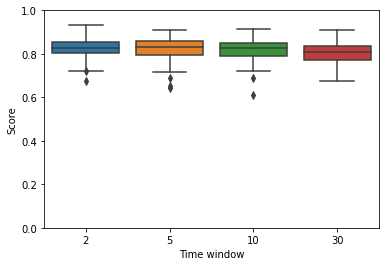

In [17]:
g = sns.boxplot(x="n_days", y="score", data=results)
g.set(xlabel='Time window', ylabel='Score')
plt.ylim(0, 1)
plt.show()


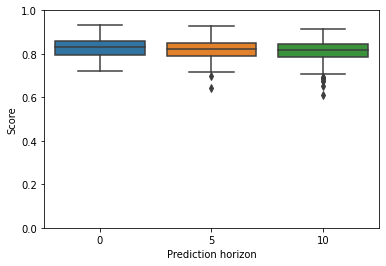

In [18]:
g = sns.boxplot(x="time_lag", y="score", data=results)
g.set(xlabel='Prediction horizon', ylabel='Score')
plt.ylim(0, 1)
plt.show()


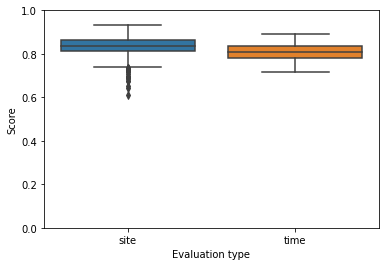

In [19]:
g = sns.boxplot(x="eval_type", y="score", data=results)
g.set(xlabel='Evaluation type', ylabel='Score')
plt.ylim(0, 1)
plt.show()


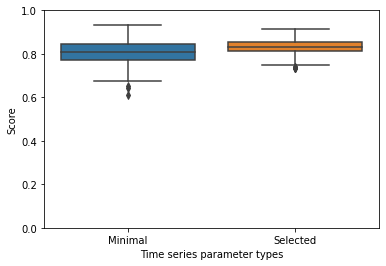

In [20]:
g = sns.boxplot(x="param_type", y="score", data=results)
g.set(xlabel='Time series parameter types', ylabel='Score')
plt.ylim(0, 1)
plt.show()


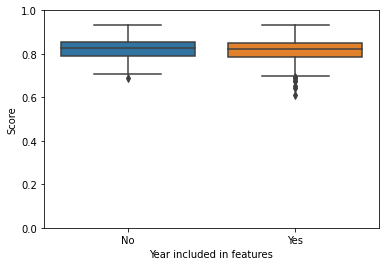

In [21]:
g = sns.boxplot(x="year", y="score", data=results)
g.set(xlabel='Year included in features', ylabel='Score')
plt.ylim(0, 1)
plt.show()


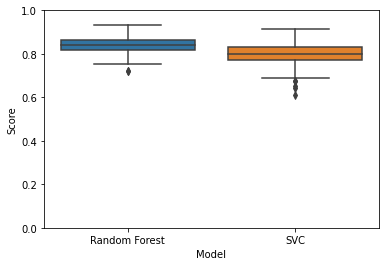

In [22]:
g = sns.boxplot(x="model", y="score", data=results)
g.set(xlabel='Model', ylabel='Score')
plt.ylim(0, 1)
plt.show()


[Text(0, 0, 'Precipitation only'),
 Text(1, 0, 'Flow only'),
 Text(2, 0, 'Temperature and precipitation'),
 Text(3, 0, 'Temperature only'),
 Text(4, 0, 'Flow and precipitation'),
 Text(5, 0, 'Flow and temperature'),
 Text(6, 0, 'Flow, temperature and precipitation')]

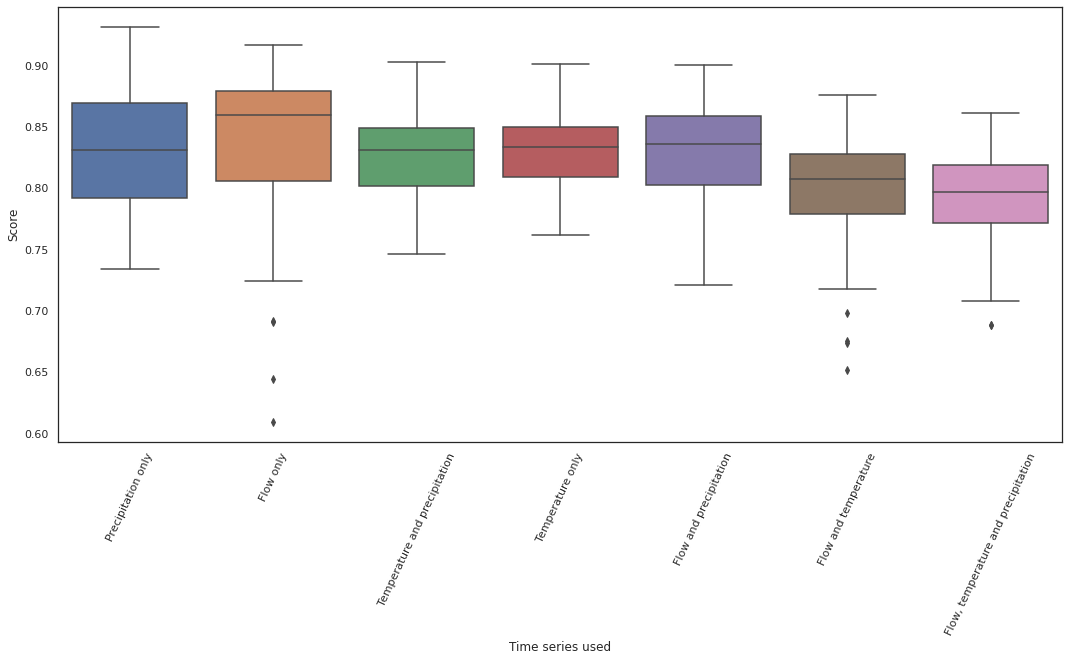

In [23]:
sns.set(rc={'figure.figsize': (18, 8)}, style='white')

g = sns.boxplot(x="time_series", y="score", data=results)
g.set(xlabel='Time series used', ylabel='Score')
g.set_xticklabels(g.get_xticklabels(), rotation=65)


## Best model chosen and feature importance

See extreme-snowmelt-climate-change.ipynb

## When does the model work well? When does it not?

See extreme-snowmelt-climate-change.ipynb

## Comparison of model confidence interval and forecasted extreme snowmelt change

See extreme-snowmelt-climate-change.ipynb